<a href="https://colab.research.google.com/github/WafaSanaa/NLP_ia/blob/main/NLP_%E2%80%93_Classification_Th%C3%A9matique_de_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install huggingface_hub

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from transformers import BertTokenizer, BertForSequenceClassification

In [7]:
data = pd.read_parquet("/content/drive/MyDrive/data/test-00000-of-00001.parquet")

In [8]:
data = pd.read_parquet("/content/drive/MyDrive/data/train-00000-of-00001.parquet")

In [9]:
print(data.shape)          # nombre de lignes et colonnes
data.head(5)

(120000, 2)


,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [10]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()  # minuscule
    text = re.sub(r'[^\w\s]', '', text)  # enlever ponctuation
    text = " ".join([word for word in text.split() if word not in stop_words])  # enlever stopwords
    return text

data["text"] = data["text"].apply(clean_text)

In [13]:
data.drop_duplicates(subset="text", inplace=True)
data = data[data["text"].str.strip() != ""]
data.reset_index(drop=True, inplace=True)

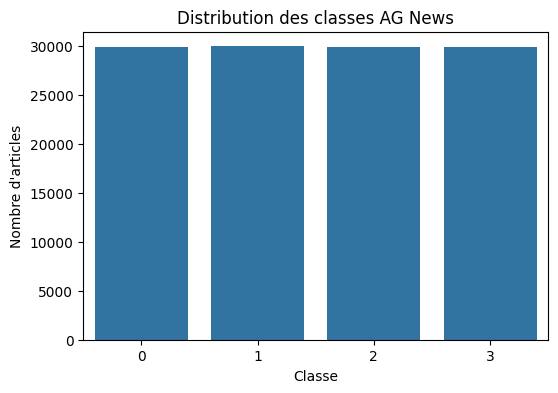

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x="label", data=data)
plt.title("Distribution des classes AG News")
plt.xlabel("Classe")
plt.ylabel("Nombre d'articles")
plt.show()


In [23]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [27]:
def generate_embeddings(texts, batch_size=32):
    model.eval()
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        inputs = tokenizer(batch, return_tensors="pt",
                           padding=True, truncation=True, max_length=128)

        with torch.no_grad():
            outputs = model(**inputs)

        # Moyenne sur les tokens (dimension 1)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

In [29]:
# Extraire les textes (titres des articles) depuis la colonne "title"
texts = data["text"].tolist()  # ou df["text"] selon ta colonne

# Générer les embeddings uniquement sur les 2000 premiers textes (pour aller vite au début)
embeddings = generate_embeddings(texts[:2000])

# Afficher la forme du premier vecteur d'embedding
print(f"Shape des embeddings : {embeddings[0].shape}")

Shape des embeddings : (768,)


In [30]:
import pickle
with open("embeddings.pkl", "wb") as f:
    pickle.dump(embeddings, f)

# Ou en .npy
np.save("embeddings.npy", embeddings)

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embeddings, data["label"][:2000], test_size=0.2, random_state=42)

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [35]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average="weighted"))
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Accuracy: 0.835
F1 Score: 0.8333590087129317
Rapport de classification :
               precision    recall  f1-score   support

           0       0.84      0.73      0.78        96
           1       0.79      1.00      0.88        61
           2       0.75      0.75      0.75        85
           3       0.90      0.88      0.89       158

    accuracy                           0.83       400
   macro avg       0.82      0.84      0.83       400
weighted avg       0.84      0.83      0.83       400



<Figure size 600x600 with 0 Axes>

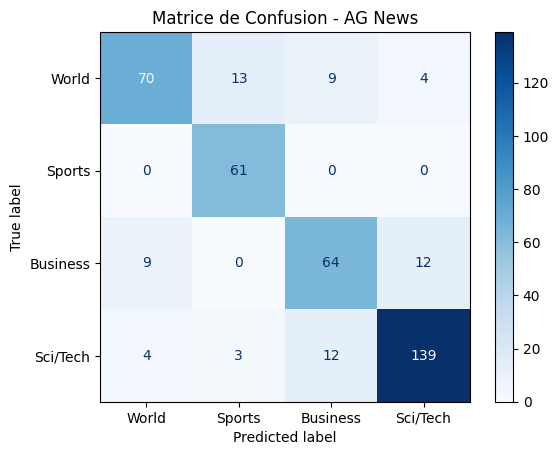

In [37]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = ['World', 'Sports', 'Business', 'Sci/Tech']

# Calcul de la matrice
cm = confusion_matrix(y_test, y_pred)

# Affichage
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Matrice de Confusion - AG News")
plt.show()

In [40]:
report = classification_report(y_test, y_pred, output_dict=True)
# Extraire les classes (exclure les clés globales comme 'accuracy', 'macro avg', 'weighted avg')
classes = [key for key in report.keys() if key not in ('accuracy', 'macro avg', 'weighted avg')]

# Récupérer le f1-score par classe
f1_scores = {cls: report[cls]['f1-score'] for cls in classes}

# Trier les classes par ordre croissant de f1-score
sorted_f1 = sorted(f1_scores.items(), key=lambda x: x[1])

print("Classes avec les plus faibles F1-score :")
for cls, f1 in sorted_f1:
    print(f"Classe : {cls}, F1-score : {f1:.3f}")

Classes avec les plus faibles F1-score :
Classe : 2, F1-score : 0.753
Classe : 0, F1-score : 0.782
Classe : 1, F1-score : 0.884
Classe : 3, F1-score : 0.888


In [41]:
pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:00


In [42]:
from datasets import Dataset

# Convertir ton dataframe en Dataset Hugging Face
dataset = Dataset.from_pandas(data)

from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)
train_dataset = Dataset.from_pandas(data_train)
test_dataset = Dataset.from_pandas(data_test)

In [43]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Indiquer les colonnes utilisées par le modèle
train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/95749 [00:00<?, ? examples/s]

Map:   0%|          | 0/23938 [00:00<?, ? examples/s]

In [45]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=data["label"].nunique())

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to=[],  # 🚫 Désactive wandb, tensorboard, etc.
)

In [53]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [55]:
trainer.save_model("model_finetuned")

In [56]:
tokenizer.save_pretrained("model_finetuned")

('model_finetuned/tokenizer_config.json',
 'model_finetuned/special_tokens_map.json',
 'model_finetuned/vocab.txt',
 'model_finetuned/added_tokens.json',
 'model_finetuned/tokenizer.json')